# Project 5: Car crash data

## Modeling Notebook
This notebook is for modeling the car crash data.  It assumes that the previous notebooks have been run. 

## Problem Statement:


In [1]:
#imports 
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix, f1_score


In [2]:
#read data
crash = pd.read_csv('./data/crash_data_modified.csv')
crash.head()

,Crash Time of Day,Collision Type,Surface Condition,Light,Traffic Control,Driver Substance Abuse,Driver At Fault,Driver Distracted By,Vehicle First Impact Location,Vehicle Second Impact Location,Vehicle Body Type,Vehicle Movement,Speed Limit,Parked Vehicle
0,Evening,SAME DIR REAR END,DRY,DAYLIGHT,STOP SIGN,No,No,No,SIX OCLOCK,SIX OCLOCK,PASSENGER CAR,STOPPED IN TRAFFIC LANE,25,No
1,Early Morning,SAME DIR REAR END,DRY,DAWN,TRAFFIC SIGNAL,No,No,No,SIX OCLOCK,SIX OCLOCK,PASSENGER CAR,STOPPED IN TRAFFIC LANE,40,No
2,Early Morning,SINGLE VEHICLE,DRY,DAYLIGHT,NO CONTROLS,No,No,No,ELEVEN OCLOCK,ELEVEN OCLOCK,POLICE VEHICLE/NON EMERGENCY,MOVING CONSTANT SPEED,35,No
3,Late Night,SINGLE VEHICLE,DRY,DARK LIGHTS ON,NO CONTROLS,No,No,No,TWELVE OCLOCK,TWELVE OCLOCK,POLICE VEHICLE/EMERGENCY,MOVING CONSTANT SPEED,35,No
4,Night,SAME DIR REAR END,DRY,DARK LIGHTS ON,NO CONTROLS,Yes,Yes,Yes,TWELVE OCLOCK,TWELVE OCLOCK,PASSENGER CAR,ACCELERATING,35,No


In [3]:
# original feature names
crash.columns

Index(['Crash Time of Day', 'Collision Type', 'Surface Condition', 'Light',
       'Traffic Control', 'Driver Substance Abuse', 'Driver At Fault',
       'Driver Distracted By', 'Vehicle First Impact Location',
       'Vehicle Second Impact Location', 'Vehicle Body Type',
       'Vehicle Movement', 'Speed Limit', 'Parked Vehicle'],
      dtype='object')

## Basic look at occurences of features in data

In [4]:
# Driver substance abuse
crash['Driver Substance Abuse'].value_counts(normalize = True)

No     0.973233
Yes    0.026767
Name: Driver Substance Abuse, dtype: float64

In [5]:
# Driver distracted by
crash['Driver Distracted By'].value_counts(normalize = True)

No     0.784361
Yes    0.215639
Name: Driver Distracted By, dtype: float64

In [44]:
crash['Crash Time of Day'].value_counts()

Evening          23814
Noon             21199
Morning          18532
Night             8853
Early Morning     8442
Late Night        3143
Name: Crash Time of Day, dtype: int64

## Handling categorical variables (one-hot encoding)

In [6]:
columns_to_dummify = ['Crash Time of Day', 'Collision Type', 'Surface Condition', 'Light',
       'Traffic Control', 'Vehicle First Impact Location',
       'Vehicle Second Impact Location', 'Vehicle Body Type',
       'Vehicle Movement', 'Parked Vehicle']

df = pd.get_dummies(crash,columns=columns_to_dummify, drop_first=True)

In [7]:
df['Driver At Fault'] = df['Driver At Fault'].map({'No':0, 'Yes':1})
df['Driver Substance Abuse'] = df['Driver Substance Abuse'].map({'No':0, 'Yes':1})
df['Driver Distracted By'] = df['Driver Distracted By'].map({'No':0, 'Yes':1})

In [8]:
df.head()

,Driver Substance Abuse,Driver At Fault,Driver Distracted By,Speed Limit,Crash Time of Day_Evening,Crash Time of Day_Late Night,Crash Time of Day_Morning,Crash Time of Day_Night,Crash Time of Day_Noon,Collision Type_ANGLE MEETS LEFT TURN,...,Vehicle Movement_PARKED,Vehicle Movement_PARKING,Vehicle Movement_PASSING,Vehicle Movement_RIGHT TURN ON RED,Vehicle Movement_SKIDDING,Vehicle Movement_SLOWING OR STOPPING,Vehicle Movement_STARTING FROM LANE,Vehicle Movement_STARTING FROM PARKED,Vehicle Movement_STOPPED IN TRAFFIC LANE,Parked Vehicle_Yes
0,0,0,0,25,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,40,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,35,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,35,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,35,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


## Setting up our features and target

In [9]:
# get X and y; train,test,split the data
X = df.drop(columns = 'Driver At Fault')
y = df['Driver At Fault']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=13424)

## Modeling

### Null Model

In [10]:
df['Driver At Fault'].value_counts(normalize = True)

0    0.556386
1    0.443614
Name: Driver At Fault, dtype: float64

For this data set 55.6% of the crashes were listed as the driver not at fault.  This means that if we assign the driver as never at fault we would have a baseline accuracy of 55.6%.  

### Simple Logistic Regression Model

In [11]:
# logistic regression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train,y_train)

LogisticRegression(max_iter=1000)

In [12]:
print('Logistic Regression metrics\n')
print('           training           testing')
print('Accuracy: ',logreg.score(X_train,y_train),logreg.score(X_test,y_test))
print('f1:       ',f1_score(y_train,logreg.predict(X_train)),f1_score(y_test,logreg.predict(X_test)))

Logistic Regression metrics

           training           testing
Accuracy:  0.8907869877911315 0.89393217755763
f1:        0.8758101496633027 0.8798748584066022


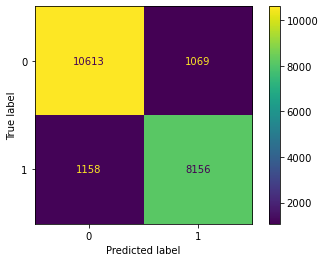

In [13]:
# confusion matrix
plot_confusion_matrix(logreg,X_test,y_test);

For the logistic regression model, the confusion matrix is fairly balanced with only slightly more Type II errors than Type I errors.  It has a fairly high accuracy and fairly high f1 score.  

In [14]:
# dataframe from the fit coefficients
logreg_coef_dict = {entry[0]:entry[1] for entry in list(zip(X.columns, logreg.coef_[0]))}
logreg_coef_df = pd.DataFrame(logreg_coef_dict.values(), index = logreg_coef_dict.keys())
logreg_coef_df.columns = ['logreg coef']

### Decision Tree Modeling

In [15]:
tree = DecisionTreeClassifier(max_depth=5)
tree.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=5)

In [16]:
print('Decision Tree metrics\n')
print('           training           testing')
print('Accuracy: ', tree.score(X_train,y_train),tree.score(X_test,y_test))
print('f1:       ',f1_score(y_train,tree.predict(X_train)),f1_score(y_test,tree.predict(X_test)))

Decision Tree metrics

           training           testing
Accuracy:  0.8617174972613396 0.8596399314155078
f1:        0.8264456222850994 0.8236490934115254


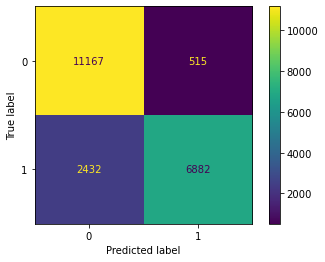

In [17]:
plot_confusion_matrix(tree,X_test,y_test);

For the decision tree model, the confusion matrix is unbalanced with vastly more Type II errors than Type I errors.  It has a fairly high accuracy and fairly high f1 score though.  

In [18]:
tree_imp_dict = {entry[0]:entry[1] for entry in list(zip(X.columns,tree.feature_importances_))}
tree_imp_df = pd.DataFrame(tree_imp_dict.values(), index = tree_imp_dict.keys())
tree_imp_df.columns = ['tree importance']
tree_imp_df.sort_values(by = ['tree importance'], ascending= False).head(20)

,tree importance
Driver Distracted By,0.497713
Vehicle First Impact Location_SIX OCLOCK,0.178323
Collision Type_SAME DIR REAR END,0.112282
Collision Type_SINGLE VEHICLE,0.082451
Vehicle Movement_MOVING CONSTANT SPEED,0.059013
Vehicle Second Impact Location_TWELVE OCLOCK,0.035352
Vehicle Movement_STOPPED IN TRAFFIC LANE,0.011978
Vehicle Movement_BACKING,0.009143
Vehicle Second Impact Location_ONE OCLOCK,0.004277
Vehicle Body Type_POLICE VEHICLE/NON EMERGENCY,0.003764


The feature importances for the decision tree model are different than for the logistic regression model.  

The tree model also shows driver distraction is the key indicator of driver responsibility in a crash.  

This also has driver substance abuse of lower importance than the in the logistic regression model.  This is very interesting and we should investigate further.  

### Random Forest

In [19]:
forest = RandomForestClassifier(max_depth = 14)
forest.fit(X_train,y_train)

RandomForestClassifier(max_depth=14)

In [20]:
print('Random Forest metrics\n')
print('           training           testing')
print('Accuracy:',forest.score(X_train,y_train),forest.score(X_test,y_test))
print('f1:      ',f1_score(y_train,forest.predict(X_train)),f1_score(y_test,forest.predict(X_test)))

Random Forest metrics

           training           testing
Accuracy: 0.9099655484465048 0.9026481234520861
f1:       0.897124716553288 0.8893460372455609


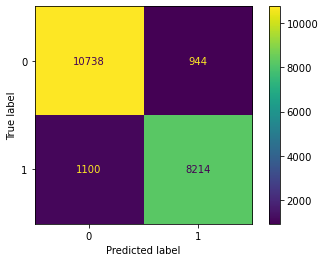

In [21]:
plot_confusion_matrix(forest,X_test,y_test);

For the random forest model, the confusion matrix is fairly balanced with slightly more Type II errors than Type I errors.  It has a high accuracy and high f1 score.  

In [22]:
forest_imp_dict = {entry[0]:entry[1] for entry in list(zip(X.columns,forest.feature_importances_))}
forest_imp_df = pd.DataFrame(forest_imp_dict.values(), index = forest_imp_dict.keys())
forest_imp_df.columns = ['forest importance']
forest_imp_df.sort_values(by = ['forest importance'], ascending= False).head(20)

,forest importance
Driver Distracted By,0.234821
Vehicle First Impact Location_SIX OCLOCK,0.100821
Vehicle First Impact Location_TWELVE OCLOCK,0.078113
Vehicle Second Impact Location_SIX OCLOCK,0.076503
Collision Type_SAME DIR REAR END,0.076391
Vehicle Movement_STOPPED IN TRAFFIC LANE,0.064893
Vehicle Movement_MOVING CONSTANT SPEED,0.047982
Vehicle Second Impact Location_TWELVE OCLOCK,0.043747
Collision Type_SINGLE VEHICLE,0.042888
Vehicle Movement_MAKING LEFT TURN,0.031239


The random forest shows similar feature importances to the tree and has about 5 points higher accuracy.  



## Model metrics

In [23]:
## model comparison
models = [logreg,tree,forest]
model_metrics = [(model.score(X_train,y_train), 
                  model.score(X_test,y_test),
                  f1_score(y_train,model.predict(X_train)),
                  f1_score(y_test,model.predict(X_test))
                 ) for model in models]
metrics_df = pd.DataFrame(model_metrics, 
                          columns = ['training_accuracy', 
                                     'testing_accuracy',
                                     'training_f1',
                                     'testing_f1'
                                    ], 
                          index = ['logreg','tree','forest'])
null_acc = df['Driver At Fault'].value_counts(normalize = True)[0]
metrics_df.loc[metrics_df.shape[0]] = [null_acc, null_acc, 'undefined', 'undefined']

metrics_df.index = ['logreg','tree','forest', 'null']

metrics_df.head()

,training_accuracy,testing_accuracy,training_f1,testing_f1
logreg,0.890787,0.893932,0.87581,0.879875
tree,0.861717,0.859640,0.826446,0.823649
forest,0.909966,0.902648,0.897125,0.889346
null,0.556386,0.556386,undefined,undefined


Comparing the models, the logistic regression and random forest both do quite well.  The forest has a slightly better testing accuracy and f1 score but shows slightly more variance.  All the models outperform the null model in which we assign all cases to be 0 (driver not at fault).  

The random forest shows slightly better scores and provides information about feature importance.  However, it does not indicate if the importance is telling us it is positively correlated or negatively correlated with fault in an accident.  For this reason, we will examine the logistic regression coefficients in addition to the random forest feature importance.  

## Model Output

We will look at the most important individual features in determining fault as well as the most important within a given category.   

### Most important features overall

In [24]:
results = pd.merge(left = forest_imp_df,right = logreg_coef_df, left_index=True, right_index=True)

In [25]:
results.sort_values('forest importance', ascending = False).head(10)

,forest importance,logreg coef
Driver Distracted By,0.234821,3.957251
Vehicle First Impact Location_SIX OCLOCK,0.100821,-2.949009
Vehicle First Impact Location_TWELVE OCLOCK,0.078113,0.694723
Vehicle Second Impact Location_SIX OCLOCK,0.076503,-1.184705
Collision Type_SAME DIR REAR END,0.076391,2.914112
Vehicle Movement_STOPPED IN TRAFFIC LANE,0.064893,-3.748021
Vehicle Movement_MOVING CONSTANT SPEED,0.047982,-1.586953
Vehicle Second Impact Location_TWELVE OCLOCK,0.043747,0.395873
Collision Type_SINGLE VEHICLE,0.042888,2.769530
Vehicle Movement_MAKING LEFT TURN,0.031239,0.906453


In [26]:
results.sort_values('logreg coef', ascending = False).head(10)

,forest importance,logreg coef
Vehicle Movement_BACKING,0.005963,4.720270
Driver Distracted By,0.234821,3.957251
Driver Substance Abuse,0.013481,3.076883
Collision Type_SAME DIR REAR END,0.076391,2.914112
Collision Type_SINGLE VEHICLE,0.042888,2.769530
Vehicle Movement_CHANGING LANES,0.017852,2.145010
Vehicle Movement_MAKING U TURN,0.002064,1.998398
Collision Type_SAME DIR REND RIGHT TURN,0.000579,1.825738
Vehicle Movement_PASSING,0.001532,1.621092
Vehicle Movement_ENTERING TRAFFIC LANE,0.001346,1.550143


In [27]:
results.sort_values('logreg coef', ascending = True).head(10)

,forest importance,logreg coef
Vehicle Movement_STOPPED IN TRAFFIC LANE,0.064893,-3.748021
Vehicle First Impact Location_SIX OCLOCK,0.100821,-2.949009
Vehicle Movement_PARKED,0.001991,-1.841602
Parked Vehicle_Yes,0.001441,-1.841602
Vehicle Movement_MOVING CONSTANT SPEED,0.047982,-1.586953
Vehicle Second Impact Location_SIX OCLOCK,0.076503,-1.184705
Vehicle Movement_SLOWING OR STOPPING,0.014365,-1.112938
Vehicle Body Type_POLICE VEHICLE/NON EMERGENCY,0.001463,-0.836050
"Surface Condition_MUD, DIRT, GRAVEL",0.000072,-0.751465
Traffic Control_PERSON,0.000053,-0.663908


In [28]:
results[results.index.str.contains('Time')].sort_values('forest importance').head()

,forest importance,logreg coef
Crash Time of Day_Night,0.000982,-0.181961
Crash Time of Day_Late Night,0.001007,-0.127688
Crash Time of Day_Morning,0.001134,-0.080577
Crash Time of Day_Noon,0.001230,-0.135375
Crash Time of Day_Evening,0.001439,-0.219541


### Most important features within a category
Isolating original features and examining which values contribute most to our undestanding of fault in the accident

#### Time of day

In [46]:
crash['Crash Time of Day'].value_counts()

Evening          23814
Noon             21199
Morning          18532
Night             8853
Early Morning     8442
Late Night        3143
Name: Crash Time of Day, dtype: int64

In [42]:
#forest
results[results.index.str.contains('Time')].sort_values('forest importance', ascending = False)

,forest importance,logreg coef
Crash Time of Day_Evening,0.001439,-0.219541
Crash Time of Day_Noon,0.001230,-0.135375
Crash Time of Day_Morning,0.001134,-0.080577
Crash Time of Day_Late Night,0.001007,-0.127688
Crash Time of Day_Night,0.000982,-0.181961


In [48]:
results[results.index.str.contains('Time')].sort_values('logreg coef', ascending = True)

,forest importance,logreg coef
Crash Time of Day_Evening,0.001439,-0.219541
Crash Time of Day_Night,0.000982,-0.181961
Crash Time of Day_Noon,0.001230,-0.135375
Crash Time of Day_Late Night,0.001007,-0.127688
Crash Time of Day_Morning,0.001134,-0.080577


#### Surface Conditions

In [47]:
crash['Surface Condition'].value_counts()

DRY                       66139
WET                       16448
ICE                         661
SNOW                        557
SLUSH                       116
MUD, DIRT, GRAVEL            26
WATER(STANDING/MOVING)       26
OIL                           9
SAND                          1
Name: Surface Condition, dtype: int64

In [31]:
forest_imp_df[forest_imp_df.index.str.contains('Surface')].sort_values('forest importance', ascending = False)

,forest importance
Surface Condition_WET,0.002090
Surface Condition_ICE,0.000509
Surface Condition_SNOW,0.000418
"Surface Condition_MUD, DIRT, GRAVEL",0.000072
Surface Condition_SLUSH,0.000069
Surface Condition_WATER(STANDING/MOVING),0.000042
Surface Condition_OIL,0.000001
Surface Condition_SAND,0.000000


In [32]:
logreg_coef_df[logreg_coef_df.index.str.contains('Surface')].sort_values('logreg coef', ascending = False)

,logreg coef
Surface Condition_SNOW,0.853109
Surface Condition_ICE,0.603895
Surface Condition_WET,0.256052
Surface Condition_WATER(STANDING/MOVING),0.165033
Surface Condition_SAND,0.029099
Surface Condition_SLUSH,-0.005173
Surface Condition_OIL,-0.027624
"Surface Condition_MUD, DIRT, GRAVEL",-0.751465


#### Traffic Control

In [33]:
forest_imp_df[forest_imp_df.index.str.contains('Traffic Control')].sort_values('forest importance', ascending = False)

,forest importance
Traffic Control_TRAFFIC SIGNAL,0.006368
Traffic Control_NO CONTROLS,0.005601
Traffic Control_STOP SIGN,0.005094
Traffic Control_YIELD SIGN,0.000427
Traffic Control_WARNING SIGN,0.000071
Traffic Control_PERSON,0.000053
Traffic Control_RAILWAY CROSSING DEVICE,0.000027
Traffic Control_SCHOOL ZONE SIGN DEVICE,0.000004


In [34]:
logreg_coef_df[logreg_coef_df.index.str.contains('Control')].sort_values('logreg coef', ascending = False)

,logreg coef
Traffic Control_RAILWAY CROSSING DEVICE,0.370901
Traffic Control_WARNING SIGN,0.309589
Traffic Control_SCHOOL ZONE SIGN DEVICE,0.047797
Traffic Control_YIELD SIGN,-0.174535
Traffic Control_NO CONTROLS,-0.281767
Traffic Control_STOP SIGN,-0.379052
Traffic Control_TRAFFIC SIGNAL,-0.379185
Traffic Control_PERSON,-0.663908


#### Light

In [35]:
forest_imp_df[forest_imp_df.index.str.contains('Light')].sort_values('forest importance', ascending = False)

,forest importance
Light_DAYLIGHT,0.001530
Light_DARK LIGHTS ON,0.001216
Light_DARK NO LIGHTS,0.000639
Light_DUSK,0.000391
Light_DAWN,0.000390


In [36]:
logreg_coef_df[logreg_coef_df.index.str.contains('Light')].sort_values('logreg coef', ascending = False)

,logreg coef
Light_DAYLIGHT,0.381402
Light_DUSK,0.305251
Light_DARK LIGHTS ON,0.231052
Light_DAWN,0.159149
Light_DARK NO LIGHTS,0.118764


#### Vehicle movement

In [37]:
forest_imp_df[forest_imp_df.index.str.contains('Movement')].sort_values('forest importance', ascending = False)

,forest importance
Vehicle Movement_STOPPED IN TRAFFIC LANE,0.064893
Vehicle Movement_MOVING CONSTANT SPEED,0.047982
Vehicle Movement_MAKING LEFT TURN,0.031239
Vehicle Movement_CHANGING LANES,0.017852
Vehicle Movement_SLOWING OR STOPPING,0.014365
Vehicle Movement_BACKING,0.005963
Vehicle Movement_MAKING RIGHT TURN,0.005138
Vehicle Movement_MAKING U TURN,0.002064
Vehicle Movement_PARKED,0.001991
Vehicle Movement_PASSING,0.001532


In [38]:
logreg_coef_df[logreg_coef_df.index.str.contains('Movement')].sort_values('logreg coef', ascending = False)

,logreg coef
Vehicle Movement_BACKING,4.720270
Vehicle Movement_CHANGING LANES,2.145010
Vehicle Movement_MAKING U TURN,1.998398
Vehicle Movement_PASSING,1.621092
Vehicle Movement_ENTERING TRAFFIC LANE,1.550143
Vehicle Movement_RIGHT TURN ON RED,1.177144
Vehicle Movement_MAKING LEFT TURN,0.906453
Vehicle Movement_LEAVING TRAFFIC LANE,0.725908
Vehicle Movement_SKIDDING,0.588319
Vehicle Movement_MAKING RIGHT TURN,0.477335


#### Substance Abuse

In [39]:
forest_imp_df[forest_imp_df.index.str.contains('Substance Abuse')].sort_values('forest importance', ascending = False)

,forest importance
Driver Substance Abuse,0.013481


In [40]:
logreg_coef_df[logreg_coef_df.index.str.contains('Substance Abuse')].sort_values('logreg coef', ascending = False)

,logreg coef
Driver Substance Abuse,3.076883


## To do: 
- collect results and write a few sentences about each
- 